## Import required libraries and data

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'



- a)

In [7]:
industry_EW = pd.read_csv('30_Industry_Portfolios_EW.CSV')
market = pd.read_csv('monthly_rf_mkt.CSV')
industry_VW = pd.read_csv('30_Industry_Portfolios_VW.CSV')

In [8]:
industry = industry_EW

In [9]:
industry = industry.rename(columns = {"Unnamed: 0":'Date'})
market = market.rename(columns={"Unnamed: 0":'Date'})

In [10]:
industry = industry[industry.Date>=197101]
industry.reset_index(inplace = True, drop= True)
industry['Date']=pd.to_datetime(industry.Date, format='%Y%m')
market = market[market.Date>=197101]
market.reset_index(inplace = True, drop= True)
market['Date']=pd.to_datetime(market.Date, format='%Y%m')

In [11]:
industries = list(industry.columns)[1:]

In [12]:
for i in industries:
    industry[i+'-RF']=industry[i]-market.RF

In [13]:
industries_rf = list(industry.columns)[31:]

In [14]:
industries_dict = {}
for i in range(len(industries)):
    industries_dict[industries_rf[i]]= industries[i]

- b)

We do the regressions based on the industry returns minus the risk free rate.

In [15]:
def regression(Y,X):
    """
    Inputs:
    Y: numpy array of shape (n,1)
    X: numpy array of shape (n,1)
    
    Outputs:
    Regression model
    """
    X = sm.add_constant(X)
    model = sm.OLS(Y, X).fit(cov_type='HC1')
    return model

In [16]:
betas = []
alphas = []
models = []
for ind  in industries_rf:
    X = market['Mkt-RF'].values
    Y = industry[ind].values
    models.append(regression(Y,X))
    betas.append(regression(Y,X).params[1])
    alphas.append(regression(Y,X).params[0])

In [30]:
reg_df = pd.DataFrame()
reg_df['Industries']= industries_rf
reg_df['Beta']= betas
reg_df['Alpha']= alphas
low_Β = np.argsort(betas)[:10]
high_Β = np.argsort(betas)[-10:]

In [33]:
for i in low_Β:
    print(industries_rf[i])

Util -RF
Beer -RF
Smoke-RF
Food -RF
Fin  -RF
Mines-RF
Meals-RF
Other-RF
Coal -RF
Paper-RF


In [18]:
data = industry.merge(market, on = 'Date')

- Low beta industries

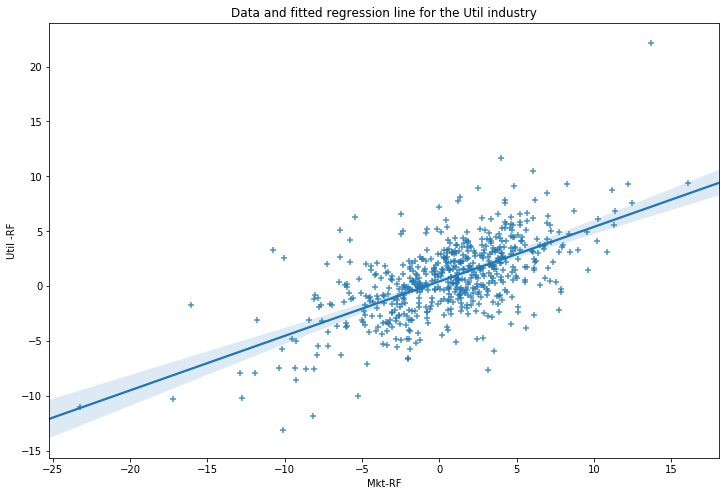

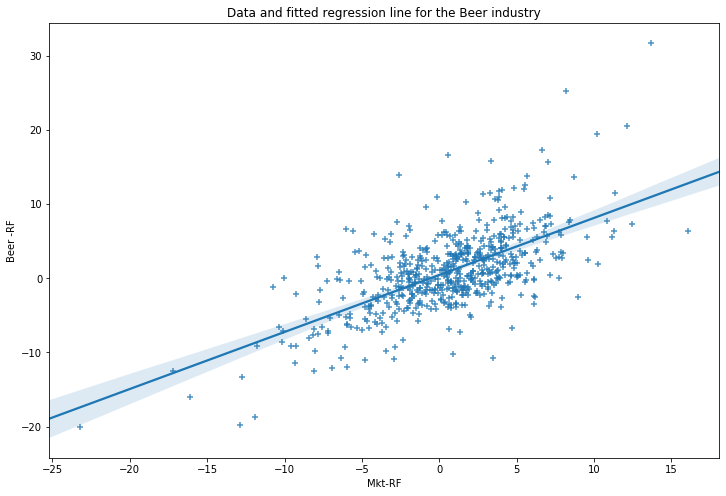

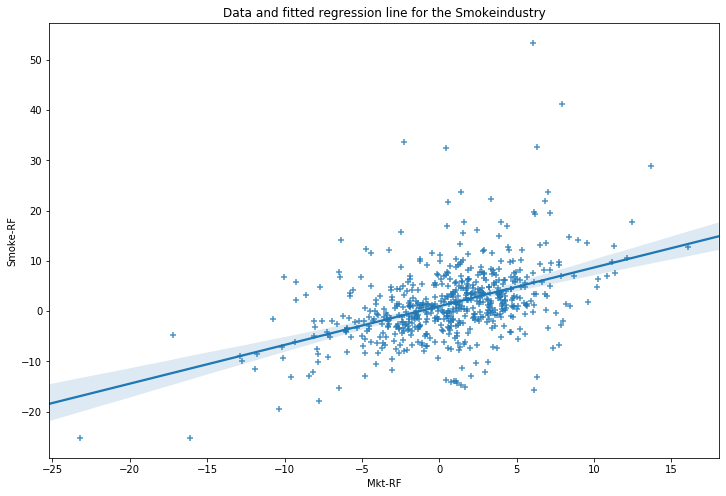

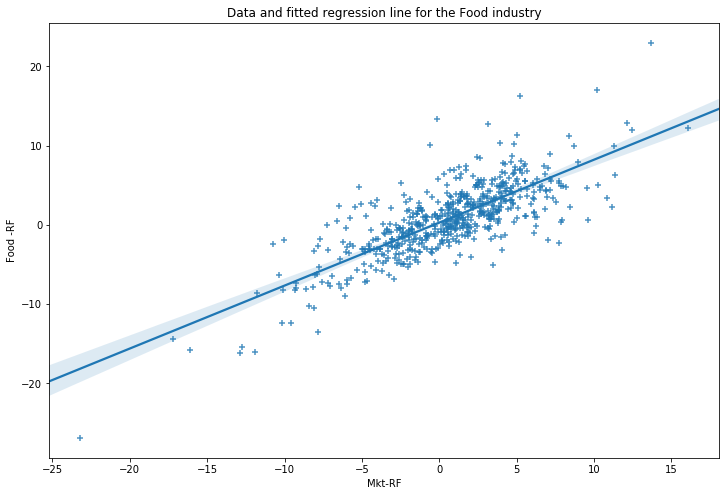

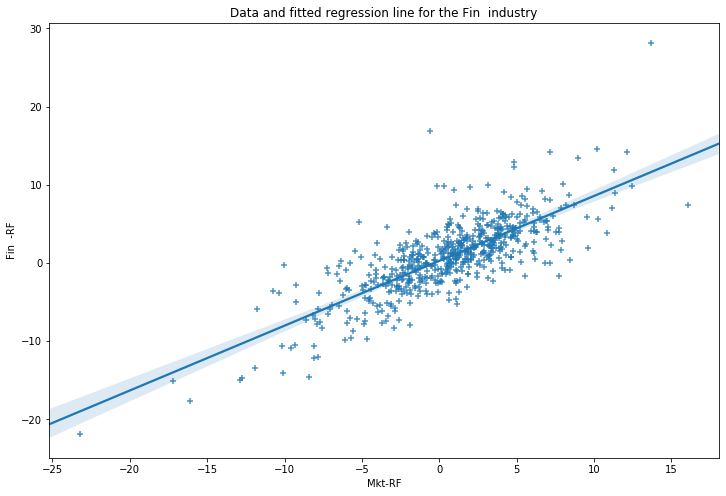

In [19]:
for i in low_Β:
    ax = plt.figure(figsize = [12,8])
    ax = sns.regplot(x='Mkt-RF', y=industries_rf[i], data=data, marker = '+')
    plt.title('Data and fitted regression line for the '+industries[i]+'industry')
    

- High beta industries

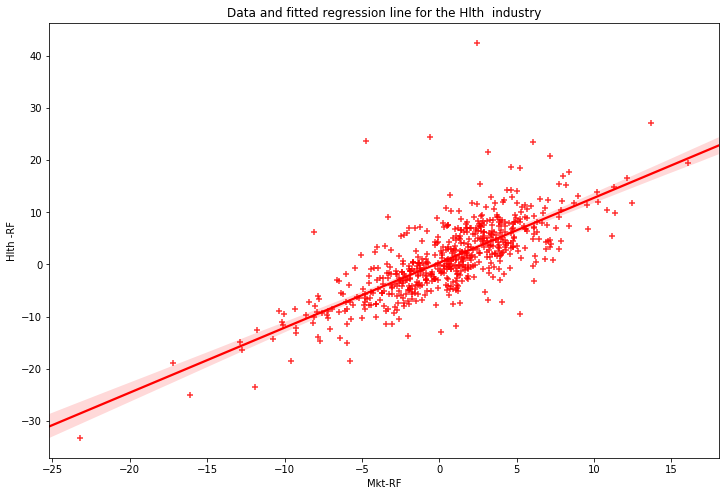

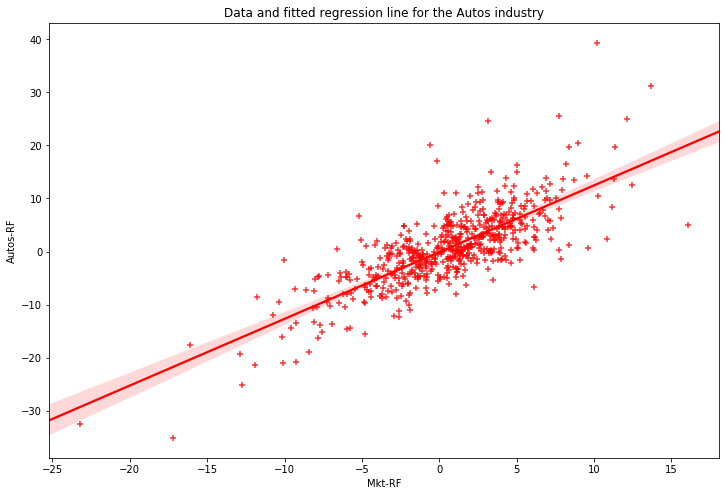

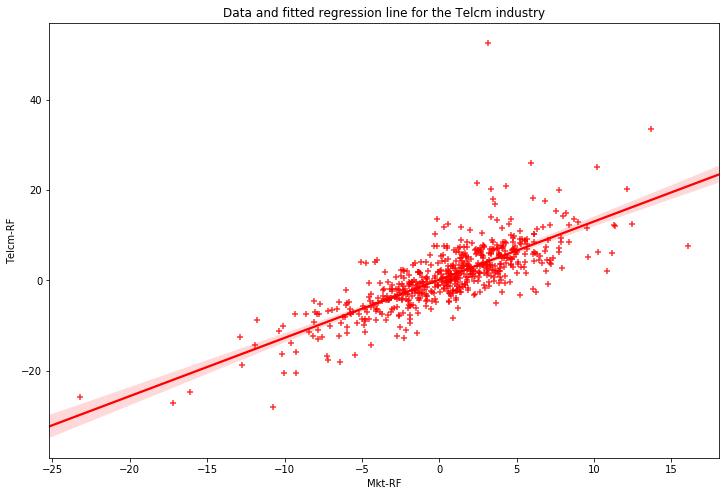

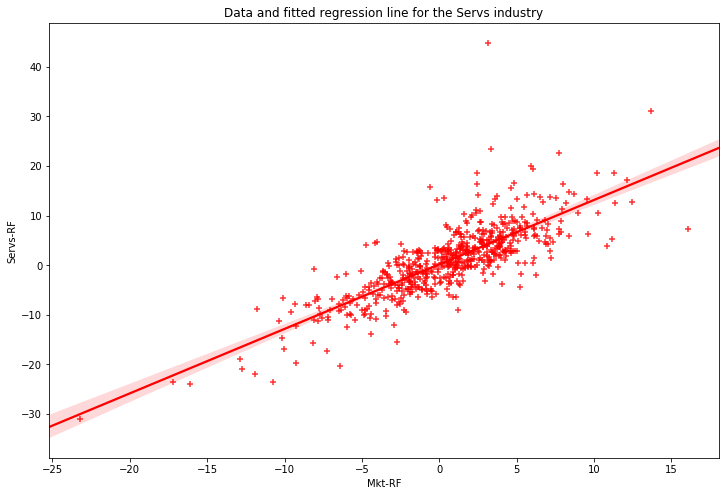

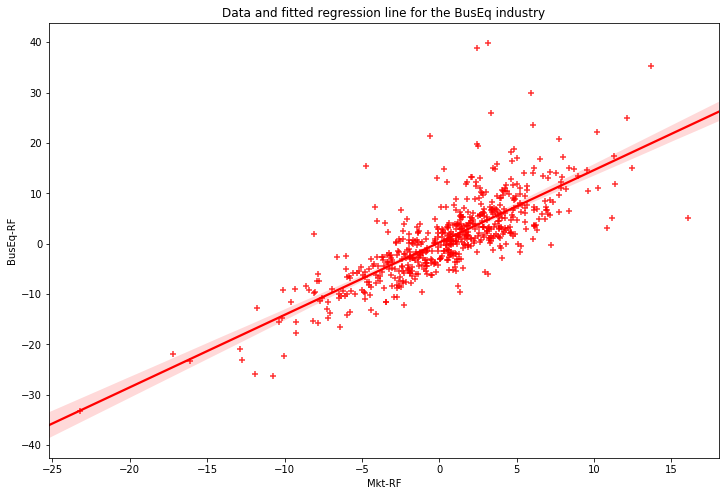

In [20]:
for i in high_Β:
    ax = plt.figure(figsize = [12,8])
    ax = sns.regplot(x='Mkt-RF', y=industries_rf[i], data=data, marker = '+', color='red')
    plt.title('Data and fitted regression line for the '+industries[i]+' industry')

Text(0.5, 1.0, 'Estimated α against estimated β for the 30 industries')

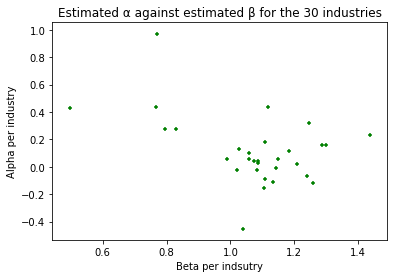

In [21]:
reg_df.plot.scatter(x = 'Beta', y ='Alpha', figsize = [6,4], c = 'green', marker= '+')
plt.xlabel('Beta per indsutry')
plt.ylabel('Alpha per industry')
plt.title('Estimated α against estimated β for the 30 industries')

- c)

Approach: use one-year rolling beta
Based on information up to t-1, we construct portfolio at t and rebalance at t+1.

In [22]:
start =data[data.Date=='1981-01-01T00:00:00.000000000'].index
end =data[data.Date=='2020-01-01T00:00:00.000000000'].index

dates = data.Date.values
period = [i for i in dates if i >=dates[start] and i <dates[end]]

In [23]:
roll_dates = []
bet = np.zeros((len(period), len(industries)))
al = np.zeros((len(period), len(industries)))

for i,p in enumerate(period):
    #print(p) # optional print statement
    roll_dates.append(p)
    for n,ind  in enumerate(industries_rf):
        #print(ind) # optional print statement
        X = data[data.Date<p]['Mkt-RF'][-12:].values
        Y = data[data.Date<p][ind][-12:].values
        #print(regression(Y,X).params[1]) # optional print statement
        bet[i,n] = regression(Y,X).params[1]
        al[i,n]= regression(Y,X).params[0]

In [70]:
β_df = pd.DataFrame(bet, columns = industries_rf)
#β_df['Dates'] = period

In [71]:
cyclical = []
defensive = []

for i in range(len(period)):
    cyclical.append(list(β_df.T[i].nlargest(5).index))
    defensive.append(list(β_df.T[i].nsmallest(5).index))

In [73]:
def_portfolio = pd.DataFrame({'Industries':defensive, 'Dates': period})
cyc_portfolio = pd.DataFrame({'Industries':cyclical, 'Dates': period})

In [262]:
def_list = [item for sublist in list(def_portfolio.Industries.values) for item in sublist]
def_ind_list = list(set(def_list))
per_def=[]
for i in def_ind_list:
    #print(i) # optional print statement
    l = [y for y in def_list if i ==y]
    #print(len(l)/(len(def_list)/5)) # optional print statement
    per_def.append(len(l)/(len(def_list)/5))

In [263]:
cyc_list = [item for sublist in list(cyc_portfolio.Industries.values) for item in sublist]
cyc_ind_list = list(set(def_list))
per_cyc=[]
for i in cyc_ind_list:
    l = [y for y in cyc_list if i ==y]
    per_cyc.append(len(l)/(len(cyc_list)/5))

Distribution of industries in portfolio composition:

In [272]:
def_changes = pd.DataFrame({'Industries':def_ind_list, 'Percentage of Days within Index': per_def})
def_changes.sort_values(['Percentage of Days within Index'], ascending = False)

,Industries,Percentage of Days within Index
25,Util -RF,0.792735
29,Beer -RF,0.517094
27,Food -RF,0.510684
28,Smoke-RF,0.423077
19,Oil -RF,0.350427
21,Mines-RF,0.301282
20,Hshld-RF,0.297009
7,Coal -RF,0.230769
15,Hlth -RF,0.205128
13,Telcm-RF,0.192308


In [273]:
cyc_changes = pd.DataFrame({'Industries':cyc_ind_list, 'Percentage of Days within Index': per_cyc})
cyc_changes.sort_values(['Percentage of Days within Index'], ascending = False)

,Industries,Percentage of Days within Index
18,Steel-RF,0.517094
7,Coal -RF,0.395299
0,BusEq-RF,0.337607
2,Servs-RF,0.324786
10,Games-RF,0.316239
12,Autos-RF,0.297009
17,FabPr-RF,0.279915
6,ElcEq-RF,0.275641
22,Cnstr-RF,0.247863
24,Rtail-RF,0.205128


In [75]:
data['Returns'] = data['Mkt-RF']+data.RF

In [93]:
def_ret = []
cyc_ret = []
for i in range(len(period)):
    def_ind = [industries_dict[x] for x in def_portfolio.Industries[i]]
    d = np.sum(data[data.Date==period[i]][def_ind].values)/5
    def_ret.append(d)
    cyc_ind = [industries_dict[x] for x in cyc_portfolio.Industries[i]]
    c = np.sum(data[data.Date==period[i]][cyc_ind].values)/5
    cyc_ret.append(c)

In [94]:
PNL_def = pd.DataFrame({'Date': period, 'Returns': def_ret})
PNL_cyc = pd.DataFrame({'Date': period, 'Returns': cyc_ret})

In [95]:
PNL_def_full = PNL_def.merge(market[['Date', 'Mkt-RF', 'RF']],how= 'inner')
PNL_cyc_full =PNL_cyc.merge(market[['Date', 'Mkt-RF', 'RF']],how= 'inner')

average excess return, market beta, alpha, Sharpe ratio, information ratio
(using market portfolio as benchmark), and maximum drawdown for the two
portfolios

In [144]:
class Portfolio_Analytics(object):
    
    def __init__(self, df):

        self.PNL = df['Returns'] 
        self.MKT = df['Mkt-RF']
        self.RF = df['RF']
        self.exret = df.Returns - df.RF
        self.diff = self.exret - self.MKT +self.RF
        #self.index = df_data.index
    
    def avg_r(self):
        #avgr = self.exret.mean()*12
        avgr = self.PNL.mean()*12
        return avgr
    
    def std_ret(self):
        stdr = self.PNL.std()*np.sqrt(12)
        
        return stdr
    
    def SR(self):
        sr = (self.exret.mean()/self.PNL.std())*np.sqrt(12)
        #sr = (self.PNL.mean()/self.PNL.std())*np.sqrt(12)
        return sr
    
    def hr(self):
        hr = len(self.PNL[self.PNL>0])/len(self.PNL)
        return hr
        
    def mkt_b(self):
        X = self.MKT.values
        Y = self.PNL.values
        return regression(Y, X).params[1]
        
        
    def mkt_a(self):
        X = self.MKT.values
        Y = self.PNL.values
        return regression(Y, X).params[0]*12
        
    
    def MaxDrawdown(self):
        '''Maximum Drawdown'''
        #i = np.argmax((np.maximum.accumulate(self.PNL) - self.PNL) / np.maximum.accumulate(self.PNL)) #end position  
        #if i == 0:
        #    return 0
        #j = np.argmax(self.PNL[:i])   # start position
        #return (self.PNL[j] - self.PNL[i]) / (self.PNL[j])
        
        #mdd = (1+self.PNL/100).cumprod()
        #mdd = ((mdd.cummax()-mdd)/mdd.cummax()).max() * 100
        #return mdd
        
        i = np.argmax(np.maximum.accumulate(self.PNL) - self.PNL) 
        j = np.argmax(self.PNL[:i]) 

        max_dd = (self.PNL[j] - self.PNL[i])/self.PNL[j]
        return max_dd
        
        
    def IR(self):
        ir = (self.exret.mean()-self.MKT.mean())/self.diff.std()*np.sqrt(12)
        return ir

In [145]:
def compute_PA(df,a='Metrics'):
    portfolio = Portfolio_Analytics(df)
    metrics = ['Sharpe Ratio', 'Max Dradwdown','Alpha', 'Beta','Hit ratio', 'Average Excess Return','Standard Deviation of Raw Returns', 'Information Ratio']
    summary_df = pd.DataFrame(index = metrics)
    summary_df[a]= [portfolio.SR(), portfolio.MaxDrawdown(), portfolio.mkt_a(), portfolio.mkt_b(), portfolio.hr(), portfolio.avg_r(),portfolio.std_ret(), portfolio.IR()]
    return summary_df

In [147]:
summary_cyc = compute_PA(PNL_cyc_full, 'Cyclical Porfolio Metrics')
summary_def = compute_PA(PNL_def_full, 'Defensive Porfolio Metrics')
print(color.BOLD + 'SHARPE RATIO, ALPHA, INFORMATION RATIO, STANDARD DEVIATION AND AVERAGE EXCESS RETURNS ARE ANNUALIZED'+ color.END)
print('\n')
print(summary_def)
print('\n')
print(summary_cyc)

SHARPE RATIO, ALPHA, INFORMATION RATIO, STANDARD DEVIATION AND AVERAGE EXCESS RETURNS ARE ANNUALIZED


                                   Defensive Porfolio Metrics
Sharpe Ratio                                         0.610699
Max Dradwdown                                        3.106008
Alpha                                                6.885930
Beta                                                 0.720023
Hit ratio                                            0.649573
Average Excess Return                               12.530359
Standard Deviation of Raw Returns                   13.998004
Information Ratio                                    0.072555


                                   Cyclical Porfolio Metrics
Sharpe Ratio                                        0.381285
Max Dradwdown                                       1.494401
Alpha                                               2.305159
Beta                                                1.286896
Hit ratio                       

- d)

Let us first fit the OLS model for both indices.

In [172]:
PNL_cyc_full['Excess Returns'] = PNL_cyc_full.Returns - PNL_cyc_full.RF
PNL_def_full['Excess Returns'] = PNL_def_full.Returns - PNL_def_full.RF

For the cyclical index:

In [173]:
PNL_cyc_full['Returns T-1'] = PNL_cyc_full['Excess Returns'].shift(1)
PNL_cyc_ols = PNL_cyc_full[1:]
PNL_cyc_train = PNL_cyc_ols[PNL_cyc_ols.Date < '2014-01-01']
PNL_cyc_test = PNL_cyc_ols[PNL_cyc_ols.Date >= '2014-01-01']
PNL_cyc_test.reset_index(drop = True, inplace =True)

In [174]:
Y_cyc = PNL_cyc_train['Returns']
X_cyc = PNL_cyc_train['Returns T-1']
model_cyc = regression(Y_cyc, X_cyc)

For the defensive index:

In [175]:
PNL_def_full['Returns T-1'] = PNL_cyc_full['Excess Returns'].shift(1)
PNL_def_ols = PNL_def_full[1:]
PNL_def_train = PNL_def_ols[PNL_def_ols.Date < '2014-01-01']
PNL_def_test = PNL_def_ols[PNL_def_ols.Date >= '2014-01-01']
PNL_def_test.reset_index(drop = True, inplace =True)

In [176]:
Y_def = PNL_def_train['Returns']
X_def = PNL_def_train['Returns T-1']
model_def = regression(Y_def, X_def)

Let us now make predictions and recover the values we will need to compute the NAV.

In [177]:
lr_cyc = LinearRegression()
lr_cyc.fit(PNL_cyc_train['Returns T-1'].values.reshape(-1,1), PNL_cyc_train['Returns'].values.reshape(-1,1))
lr_cyc_pred = lr_cyc.predict(np.array(PNL_cyc_test['Returns T-1']).reshape(-1,1))
PNL_cyc_test['Pred'] = lr_cyc_pred

In [178]:
lr_def = LinearRegression()
lr_def.fit(PNL_def_train['Returns T-1'].values.reshape(-1,1), PNL_def_train['Returns'].values.reshape(-1,1))
lr_def_pred = lr_def.predict(np.array(PNL_def_test['Returns T-1']).reshape(-1,1))
PNL_def_test['Pred'] = lr_def_pred

In [208]:
sigma_2_cyc =np.var(model_cyc.resid)
sigma_2_def =np.var(model_def.resid)
cov=np.cov(model_cyc.resid,model_def.resid)[0][1]

We now check the MSEs to get an idea of how well the model does.

In [187]:
mse_def = mean_squared_error(np.array(PNL_def_test['Returns']).astype(float),np.array(PNL_def_test['Pred']).astype(float))
mse_def

11.864050787663011

In [188]:
mse_cyc = mean_squared_error(np.array(PNL_cyc_test['Returns']).astype(float),np.array(PNL_cyc_test['Pred']).astype(float))
mse_cyc

24.645846417353557

We now compute the NAV.

In [209]:
dates_nav = PNL_def[PNL_def.Date >= '2014-01-01'].Date.values


data_c = PNL_cyc[PNL_cyc.Date >= '2014-01-01'].Returns.values
data_d = PNL_def[PNL_def.Date >= '2014-01-01'].Returns.values


mus_c = PNL_cyc_test.Pred.values
mus_d = PNL_def_test.Pred.values


var_c = [sigma_2_cyc]*len(dates_nav)
var_d = [sigma_2_def]*len(dates_nav)


We find the weights by solving the mean variance optimization problem, as instructed on Canvas.

In [210]:
def NAV(data_a1, data_a2, mu_1, mu_2, sigma_1, sigma_2, cov, init_cap, dates, alpha):
    
    nav = pd.DataFrame()
    nav['Date']=dates
    r = []
    weight = []
    for i in range(len(dates)):
        w = ((mu_1[i] - mu_2[i])+alpha*(sigma_2[i]-cov))/(alpha*(sigma_1[i]+sigma_2[i]-2*cov))
        
        res = w*data_a1[i]+(1-w)*data_a2[i]
        
        r.append(res)
        weight.append(w)
        
    nav['Weight']=weight
    nav['Returns'] = r
    nav['NAV'] = init_cap*(1+((nav.Returns/100 +1).cumprod()-1))
    return nav

Let us now have a look at the results.

In [224]:
nav_1 = NAV(data_c, data_d,mus_c, mus_d, var_c, var_d, cov, 1, dates_nav,1)
nav_10 = NAV(data_c, data_d,mus_c, mus_d, var_c, var_d, cov, 1, dates_nav,10)

Text(0, 0.5, 'NAV')

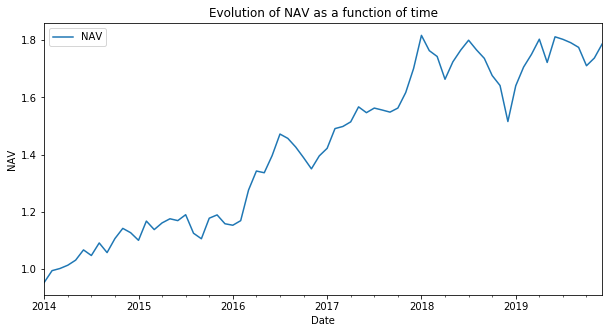

In [226]:
nav_1.plot(x='Date', y = 'NAV', figsize = [10,5])
plt.title('Evolution of NAV as a function of time')
plt.ylabel('NAV')

In [222]:
nav_1_full = nav_1.merge(market, how = 'inner')
#nav_1_full # optional print statement

In [214]:
compute_PA(nav_1_full, 'Market Timing Alpha = 1')

,Market Timing Alpha = 1
Sharpe Ratio,0.804582
Max Dradwdown,1.838142
Alpha,1.995571
Beta,0.778373
Hit ratio,0.555556
Average Excess Return,10.405894
Standard Deviation of Raw Returns,11.914128
Information Ratio,-0.152974


Text(0, 0.5, 'NAV')

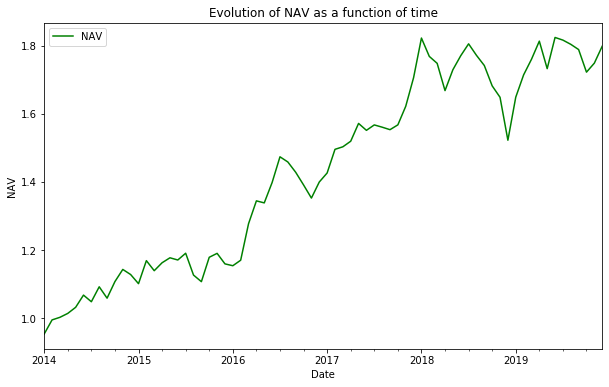

In [228]:
nav_10.plot(x='Date', y = 'NAV', figsize = [10,6], color = 'green')
plt.title('Evolution of NAV as a function of time')
plt.ylabel('NAV')

In [219]:
nav_10_full = nav_10.merge(market, how = 'inner')
#nav_10_full # optional print statement

In [199]:
compute_PA(nav_10_full, 'Market Timing Alpha = 10')

,Market Timing Alpha = 10
Sharpe Ratio,0.659337
Max Dradwdown,1.959271
Alpha,-0.781678
Beta,0.875647
Hit ratio,0.583333
Average Excess Return,8.679692
Standard Deviation of Raw Returns,11.920609
Information Ratio,-0.489145


We can observe that with this strategy, we are much more exposed to market fluctuations than in the previous one. Over the period, this strategy performs better than the previous ones we computed in the last problem set except when using OLS with alpha = 1. We should also compute the portfolio analytics for the previous strategies to get a sense for their risk/return profiles.